In [2]:
from jax import random, numpy as jnp
from stadion.models import LinearSDE, MLPSDE
from pprint import pprint
from stadion import kds_loss
from scipy.linalg import solve_continuous_lyapunov
import numpy as onp

2025-01-26 16:51:02.203673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-26 16:51:02.214953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-26 16:51:02.218282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 16:51:02.791636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from nn import NNSDE

In [3]:
n = 20000
d = 5
r = 2
n_envs = 2
epsilon = 0.2
gamma = 0.95
activation = "linear"
n_samples_burnin=200

In [4]:
key = random.PRNGKey(3)
true_model = NNSDE(
    hidden_size = r,
    activation=activation,
    epsilon=epsilon,
    gamma=gamma,
    sde_kwargs = {"n_samples_burnin": n_samples_burnin})
true_model.n_vars = d

key, subk = random.split(key)
param = true_model.init_param(subk, d, scale=0.1)
param["mlp_b_0"] = 0 #No bias terms
true_model.param = param

targets = [jnp.zeros(d)]
for k in range(n_envs-1):
    target = jnp.array([0] * d)
    target = target.at[k].add(1)
    targets.append(target)

key, subk = random.split(key)
true_intv_param = true_model.init_intv_param(subk, d = d, scale=1.0, n_envs = n_envs, targets = targets)

datasets = []
for k in range(n_envs):
    local_intv_param = true_intv_param.index_at(k)
    key, subk = random.split(key)
    data = true_model.sample(subk, n_samples = n, intv_param = local_intv_param)
    datasets.append(data)

In [5]:
B = param["mlp_0"].T
A = param["mlp_1"].T
D = jnp.diag(jnp.exp(param["log_reversion"]))
print(A.shape, B.shape, D.shape)
L = true_model.gamma * A @ B - D

(5, 2) (2, 5) (5, 5)


In [6]:
### Validate this is the correct drift?
key, subk = random.split(key)
x = random.normal(subk, shape=(3,d))
out_1 = true_model.f(x, param, None)
out_2 = x @ L.T
print(out_1)
print(out_2)

[[-1.8866414  -0.096493   -0.27212825  1.1807656   0.4480015 ]
 [-0.42910784 -0.8657925   0.40399036 -1.6426626   0.47038716]
 [ 1.3701317  -1.8162863  -2.7622209  -0.60249746  0.16114491]]
[[-1.8866413  -0.09649301 -0.27212825  1.1807656   0.4480015 ]
 [-0.4291079  -0.8657925   0.4039903  -1.6426628   0.47038713]
 [ 1.3701317  -1.8162866  -2.7622209  -0.60249746  0.16114487]]


Array([-1.1312785 ,  0.14686859,  0.10555197, -0.09656211,  0.00597531],      dtype=float32)
Array([-1.1330327 ,  0.14876719,  0.10617722, -0.09877131,  0.00640062],      dtype=float32)


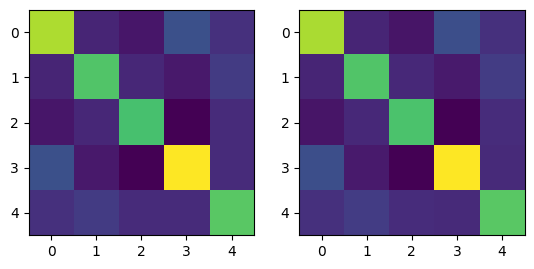

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

data = datasets[1]
mean = jnp.mean(data, axis = 0)
cov = jnp.cov(data, rowvar=False)

c = true_intv_param.index_at(1)["shift"]
L_inv = jnp.linalg.inv(L)
mean_true = -L_inv @ c
Q = epsilon * onp.identity(d)
cov_true = solve_continuous_lyapunov(L, -Q @ Q.T)

pprint(mean)
pprint(mean_true)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cov)
ax2.imshow(cov_true)
plt.show()

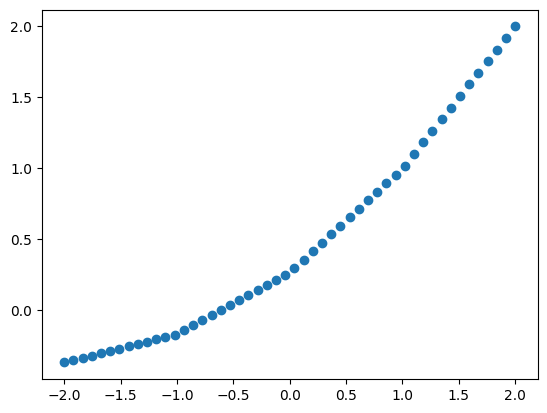

In [7]:
import jax
import matplotlib.pyplot as plt
%matplotlib inline

# cursed = lambda arr: 0.5 * jax.nn.leaky_relu(arr) + 0.5 * jax.nn.leaky_relu(arr - 1)
cursed = lambda arr: 
cursed = lambda arr: 1.0/3.0 * (jax.nn.leaky_relu(arr, 0.1) + jax.nn.leaky_relu(arr - 1, 0.2) + jax.nn.leaky_relu(arr + 1, 0.3))
xs = jnp.linspace(-2, 2, num=50)
plt.scatter(xs, cursed(xs))